## 3.3 학습 데이터 준비
데이터를 준비해서 학습을 해볼 것이다.
간단한 예제로 지금까지 썼던 'You say goodbye and I say hello.'라는 한 문장짜리 말뭉치를 이용한다.

### 3.3.1 맥락과 타깃
word2vec에서 이용하는 신경망의 입력은 '맥락'이다. 그리고 그 정답 레이블은 맥락에 둘러싸인 중앙의 단어, 즉 '타깃'이다.  
다시 말해, 우리가 해야 할 일은 신경망에 '맥락'을 입력했을 때 '타깃'이 출현할 확률을 높이는 것이다.
![](https://github.com/yesinkim/Deep-Learning-From-Scratch2/blob/main/deep_learning_2_images/fig%203-16.png?raw=true)  
위 그림에서는 말뭉치로부터 목표로 하는 단어를 '타깃'으로, 그, 주변 단어를 '맥락'으로 뽑아 냈다.  
다시 단어를 인덱스로 변환해주는 preprocess 함수를 사용한다.

In [5]:
import sys
# from ..utils import preprocess

text = 'You say goodbye and I say hello'
corpus, wor_toid, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


![](https://github.com/yesinkim/Deep-Learning-From-Scratch2/blob/main/deep_learning_2_images/fig%203-17.png?raw=true)  
위 그림 처럼 맥락은 2차원 배열이다. 이 때 맥락의 0번째 차원에는 가 맥락 데이터가 저장된다. contexts[0]에는 0번째 맥락이, target[0]에는 0번째 타겟이 저장되는 것이다.

In [9]:
import numpy as np

def crate_contexts_target(corpus, window_size):
    """Create contexts target

    Args:
        corpus (list): 단어 ID 배열
        window_size (int): 맥락의 윈도우 크기(타겟을 기준으로 앞 뒤로 몇 개를 볼 것인지?)

    Returns:
        (contexts, target)
    """
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [14]:
contexts, target = crate_contexts_target(corpus, window_size=1)

print(contexts)
print(target)


[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]]
[1 2 3 4 1]


이렇게 맥락과 타겟을 만들어 냈다. 이것을 나중에 CBOW모델에 넘겨주면 된다. 그런데 생각해보니 이 맥락과 타겟의 원소는 여전히 ID이다.  이것을 원핫 인코딩해주겠다.

### 3.3.2 원핫 표현으로 변환
계속해서 맥락과 타겟을 원핫 표현으로 바꿔보자. 이 때 수행하는 변환은  
`[0, 2] -> [[1,0,0], [0,0,2]]` 로 변환하는 것 과 같다.

이 때 다시 한번 각각의 다차원 배열의 형상에 주목해야 한다. 잘 보면, 이 그림에서는 단어ID를 이용했을 때의 맥락의 형상은 (6,2)인데, 이를 원핫 표현으로 변환하면 (6,2,7)이 된다. 원핫 표현으로 변환은 이 책이 제공하는 `convert_one_hot()` 함수를 사용한다.

In [15]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환
    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [17]:
# 지금까지의 과정을 모두 한 데 모아 정리하면 아래와 같다.

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = crate_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

이렇게 학습 데이터 준비를 마쳤다. 본론인 CBOW 모델을 구현해보자.

## 3.4. CBOW 모델 구현


In [5]:
# simple_cbow.py
import sys

sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

import numpy as np

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.rand(V, H).astype('f')
        W_out = 0.01 * np.random.rand(H, V).astype('f')

        # 계층 생성 (입력 레이어는 맥락에서 사용하는 단어의 수 만큼 만들어야 함. 해당 예제에서는 앞 뒤로 두개.)
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치오 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da * 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None


여기서 인수 contexts는 3차원 넘파이 배열이라고 가정했을 때 이 배열의 형상은 (6, 2, 7)이 된다. 0번째 차원은 미니배치의 수이고, 1번째 차원은 맥락의 운도우 크기, 2번째 차원은 원핫 벡터이다. 또한, target의 형상은 2차원으로 (6,7)의 형상이 된다. 마지막으로 역전파인 backward()를 구현한다.

![](https://github.com/yesinkim/Deep-Learning-From-Scratch2/blob/main/deep_learning_2_images/fig%203-20.png?raw=true)  
신경망의 역전파는 기울기를 순전파 때와는 반대 방향으로 전파한다. 이 역전파는 '1'에서 시작해 곧바로 Softmax with Loss 계층에 입력된다. 그리고 Softmax with Loss 계층의 역전파 출력이 ds이며, 이 ds를 출력 측 Matmul 계층으로 입력한다.

그런 다음'x'와 '+' 연산으로 역전파된다. 'x'의 역전파는 순전파 시의 입력을 '서로 바꿔'기울기에 곱한다. '+'의 역전파는 기울기를 그대로 통과시킨다.

In [ ]:
def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da * 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [3]:
import os

os.chdir('..')
# print(os.getcwd())
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

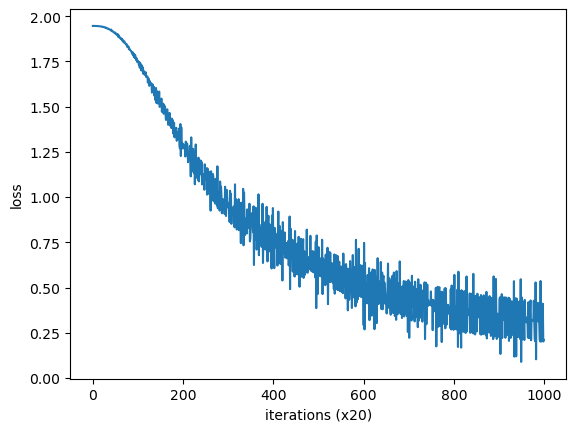

In [6]:
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

Trainer는 1장에서 설명한 방식으로 신경망을 학습시킨다. 즉, 학습 데이터로부터 미니배치를 선택한 다음, 신경망에 입력해 기울기를 구하고, 그 기울기를 Optimizer에 넘겨 매개변수를 갱신하는 일련의 작업을 수행한다.
> NOTe_ 앞으로도 Trainer는 계속 사용할 것이다.

위의 그래프를 보면 학습을 거듭할수록 손실이 줄어드는 것을 알 수 있다. 그러면 학습이 끝난 후의 가중치 매개변수를 살펴보자.

In [8]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.0976636  1.0441817  1.7296913 -1.1077722  1.0979917]
say [ 1.3044391  -0.02456458  0.97267085  1.3037568   0.8420969 ]
goodbye [-1.048725   0.7986982 -0.9112385 -1.0485396  0.860819 ]
and [ 1.3063837  1.886075   0.7127069  1.3039242 -0.5429939]
i [-1.057061    0.79252285 -0.8971362  -1.0549129   0.8580602 ]
hello [-1.0925217  1.044513   1.7216983 -1.1033494  1.093302 ]
. [ 0.8444648  -1.595918    0.98447317  0.86095613  1.7634803 ]


word_vecs라는 이름으로 가중치를 꺼내는데, 각 행에는 대응하는 단어ID의 분산 표현이 저장 되어 있다. 마침내 우리는 단어를 밀집벡터로 나타낼 수 있게 되었다.
아쉽지만 작은 말뭉치로 좋은 결과를 얻을 수 없기 때문에 4장에서 단순한 CBOW를 개선해서 '진짜'CBOW 모델을 구현할 계획이다.